# Sentiment measurement of Tweets

This time we will explore the sentiment changes, if there's any, shortly before and after the launch of the space exploration computer/video game - No Man's Sky.

In [1]:
# -*- coding: utf-8 -*-
# https://github.com/n-lo/Tweets_analysis_tryout
%matplotlib inline
from __future__ import print_function
from pymongo import MongoClient
import pprint, datetime
import pandas as pd
import numpy as np
import gensim, re
from dateutil import parser
from ggplot import *

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# e.g. logging.info("%i tweets found..." % len(df))

pp = pprint.PrettyPrinter(indent=4)

## Retrieving data (Tweets) from MongoDB

#### 1. connect to MongoDB

In [2]:
print("Open connection to MongoDB.")
client = MongoClient('localhost', 27017)
db = client.nms.tweets
print("Total number of tweets in db: ", db.count())

Open connection to MongoDB.
Total number of tweets in db:  165272


#### 2. find all tweets written in English and return specific fields only

In [3]:
print("Finding tweets in database.")
datain = db.find({ "lang" : "en" }, 
                 { "created_at" : 1, "favourite_count" : 1, "id_str" : 1, "lang" : 1, "place" : 1, 
                  "retweet_count" : 1, "text" : 1, "user" : 1 })
print("%i tweets found." % datain.count())

Finding tweets in database.
125457 tweets found.


#### 3. store data in dataframe

In [4]:
print("Storing into dataframe...")
df = pd.DataFrame(list(datain))
print("Done.\n%d entries stored." % len(df))

Storing into dataframe...
Done.
125457 entries stored.


#### 4. now do a bit of cleaning up, and "flatten" the nested user item

In [5]:
print("Check for duplicates with id_str.")
df.drop_duplicates(subset='id_str', keep='last', inplace=True)
print("Number of tweets after dropping duplicates (using id_str tag): %d" % len(df))

Check for duplicates with id_str.
Number of tweets after dropping duplicates (using id_str tag): 125433


In [6]:
print("Storing nested 'user' items into separate dataframe...")
df_users = pd.io.json.json_normalize(list(df['user']))

Storing nested 'user' items into separate dataframe...


In [7]:
# quick sanity check
print("Number of 'user' entries in df: %d" % len(df_users))

Number of 'user' entries in df: 125433


In [8]:
print("Tidy up dataframes - dropping unused columns for our purposes here.")
df_users.drop(['default_profile', 'default_profile_image', 'profile_background_color', 
               'profile_background_image_url', 'profile_background_image_url_https', 
               'profile_background_tile', 'profile_banner_url', 'profile_image_url',
               'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 
               'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image'],
              axis = 1, inplace = True)

print("Renaming user columns with prefix 'user_' before joining both tables.")
cnames = df_users.columns
cnames = ["user_"+n for n in cnames]
df_users.columns = cnames

Tidy up dataframes - dropping unused columns for our purposes here.
Renaming user columns with prefix 'user_' before joining both tables.


In [9]:
print("Joining tweets and users dataframes...")
df_join = df.join(df_users)

Joining tweets and users dataframes...


In [10]:
# sanity check...
print("Joined df has %d entries." % len(df_join))

Joined df has 125433 entries.


In [11]:
del(df_users, df)
df = df_join
del(df_join)

## A quick look at the data set

#### Note:  
If memory is still an issue (my poor old laptop), try select a portion of the data for analysis.  

from sklearn.cross_validation import train_test_split  
train, test = train_test_split(df, test_size = 0.5)  
del(df)  
df = train

This data set contains 51881 retweets out of a total of 125433 tweets


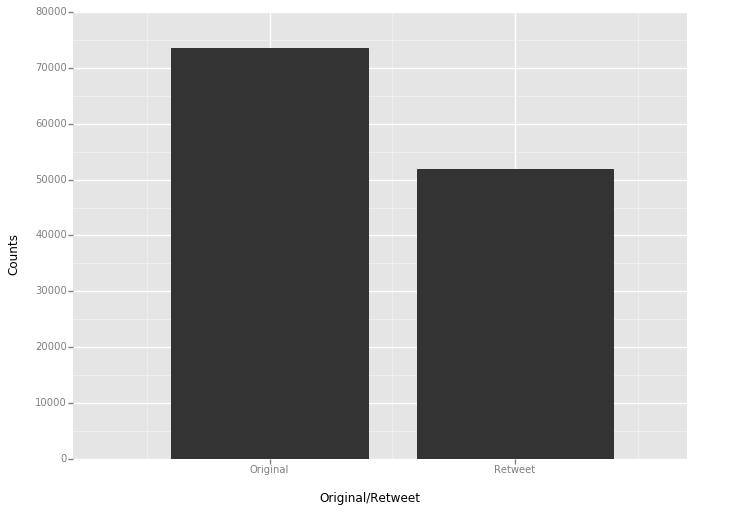

<ggplot: (11353541)>

In [12]:
df['retweet'] = 0

for index, row in df.iterrows():
    text = row['text']
    match = re.search(r'^\bRT\b', text)
    if match:
        df.set_value(index, 'retweet', 1)

print("This data set contains %i retweets out of a total of %i tweets" % 
      (sum(df['retweet']), len(df)))

ggplot(df, aes(x = 'retweet')) + geom_bar() + \
    scale_x_continuous(labels = ["Original", "Retweet"]) + xlab("Original/Retweet") + ylab("Counts")

In [13]:
# most retweeted tweets
high_RT = df[df['retweet_count'] >= np.percentile(df['retweet_count'], 95)]
print(high_RT['text'].unique())

[ u'RT @PlayStationJobs: #WIN a copy of #NoMansSky \n\nFOLLOW + RETWEET + LIKE to ENTER\n\nWinner picked at random on Tuesday 9 August 5pm https://\u2026'
 u'RT @PlayStation: Two weeks to go. #NoMansSky https://t.co/JZ7CSDymz7'
 u'#WIN a copy of #NoMansSky \n\nFOLLOW + RETWEET + LIKE to ENTER\n\nWinner picked at random on Tuesday 9 August 5pm https://t.co/GDA5bCeRKf'
 u"RT @thatkindanerdy: I fell like I have waited so long for #NoMansSky, that I'll be sat there at 23:59 the day before release and suddenly i\u2026"
 u'RT @space_mannequin: No mans sky nightmare.\n\n#NoMansSky https://t.co/xAJJqcpwFt'
 u'RT @totinos: Geez, #NoMansSky, stop reading my mind. https://t.co/rn4UDaBJjI'
 u'RT @PlayStationUK: &lt;START TRANSMISSION #NoMansSky/]&gt;\n        A MESSAGE FROM OUR COSMIC EMPEROR @BillBailey\n\n   &lt;END&gt;\nhttps://t.co/40zogPeXMC'
 u'RT @epyoncf: I guess this illustrates a serious problem with how gamers see game development effort :/ #NoMansSky #gamedev https://t.co/H0Z\u2026']


In [14]:
# count number of tweets by each user
df['tweets_cnt'] = 0
df['tweets_cnt'] = df.groupby('user_id').transform('count')
df['tweets_cnt'].describe()

count    125433.000000
mean         13.687602
std          39.187429
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         415.000000
Name: tweets_cnt, dtype: float64

In [15]:
print("%d unique twitter users in this data set." % len(df['user_id'].unique()))

62147 unique twitter users in this data set.


In [16]:
df_active_twitters = df[df['tweets_cnt'] >= np.percentile(df['tweets_cnt'], 95)]
print("%d users in the top 5 per cent tweets count." % 
      len(df_active_twitters['user_id'].value_counts()))

58 users in the top 5 per cent tweets count.


In [17]:
df_active_twitters = df_active_twitters.drop_duplicates(subset='user_id', keep='last')
print('Information on the top 5 per cent most active twitter users.')
df_active_twitters[['user_description', 'user_created_at', 
                    'user_location', 'tweets_cnt']]

Information on the top 5 per cent most active twitter users.


,user_description,user_created_at,user_location,tweets_cnt
85325,Twitch and Gaming News Reporter Maintained by ...,Wed Dec 09 00:05:09 +0000 2015,,128
89928,,Wed Aug 10 06:19:44 +0000 2016,,69
97263,{♿️} artist. observer. curiosity. wonder |bir...,Tue Dec 02 01:39:06 +0000 2008,"British Columbia, Canada",110
99152,"Swedish female gamer, Let's Player and Digital...",Sun Jan 18 16:38:09 +0000 2009,Sweden,66
108344,This is the Retweet account for D2S. We mainly...,Sat May 07 00:23:59 +0000 2016,,82
114810,Violent Gunny Slayer. Beta tester w/ SCEE. Typ...,Fri Jun 26 20:05:56 +0000 2009,,65
116555,"i love smoking weed, playing video games, list...",Fri Jun 14 17:59:24 +0000 2013,u.k,67
117254,A record of my travels.,Wed Apr 20 02:44:23 +0000 2016,Spaaaaaaaaaaaaaace,81
119750,Back Up Account For @DNR_CREW ----------------...,Fri Apr 08 13:14:17 +0000 2016,@RTDNR @DNR_CREW,78
119766,Just some random geek/artist/writer.,Tue Jan 10 18:53:58 +0000 2012,Cleveland,95


I was expecting quite a number of media outlets, commercial channels, but no.

## Sentiment analysis
### 1. Calculate sentiment scores
#### Import positive and negative words  
with AFINN valence rated words from
http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010

In [18]:
wd_file = "AFINN-111.txt"

afinn = dict(map(lambda (k,v): (k,int(v)), [ line.split('\t') for line in open(wd_file) ]))

#### Add in my list of negative words commonly found with computer/video gaming

In [19]:
my_neg_wd = ['overhype', 'overhyped', 'ctd', 'lag', 'tedious', 'overprice', 'overpriced',
             'bug', 'bugs', 'oversight', 'oversights', 'grindy', 'refund', 'crash', 'crashes',
             'stuttering', 'unplayable', 'hitching']
#neg_wd |= set(my_neg_wd)

afinn['bug'] = -2
afinn['buggy'] = -3
afinn['crash'] = -4
afinn['ctd'] = -4
afinn['grindy'] = -2
afinn['hitching'] = -3
afinn['lag'] = -2
afinn['lackluster'] = -2
afinn['overhype'] = -3
afinn['overhyped'] = -3
afinn['overpriced'] = -3
afinn['oversights'] = -1
afinn['refund'] = -4
afinn['tedious'] = -2
afinn['unplayable'] = -5

#### Get a list of stopwords

In [20]:
# stopwords
sw = set(gensim.parsing.preprocessing.STOPWORDS)
my_sw = ['http', 'https', 'RT']

#### Functions to remove URLs, then tokenize text

In [21]:
def split_wd(text, stopwords=sw):
    new_sw = set(sw)
    new_sw |= set(my_sw)
    return [wd
            for wd in gensim.utils.tokenize(text, lower=True)
            if wd not in new_sw and len(wd) > 3]

In [22]:
# funct to remove links, channel names from string
def remove_url(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@+", " ", text)
    return text

#### Calculate the sentiment score for each Tweets

In [23]:
df['sentiment_afinn'] = 0

for index, row in df.iterrows():
    text = row['text']
    text = remove_url(text)
    tokens = split_wd(text, sw)

    score = sum(map(lambda word: afinn.get(word, 0), tokens))
    df.set_value(index, 'sentiment_afinn', score)

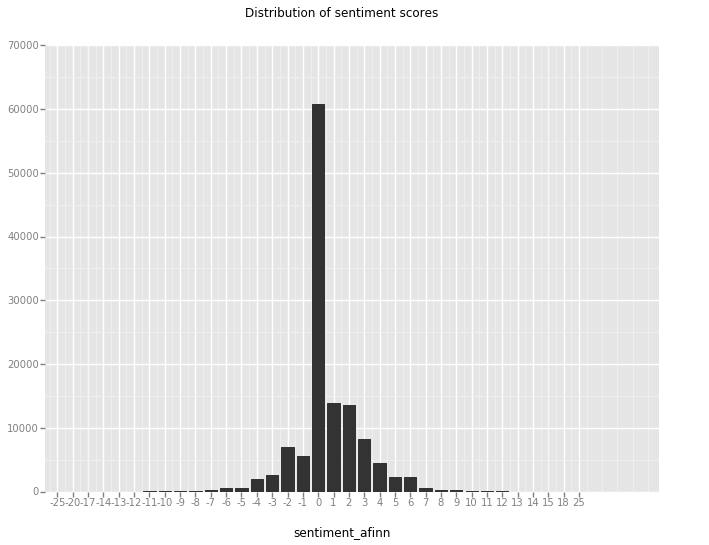

<ggplot: (148127296)>


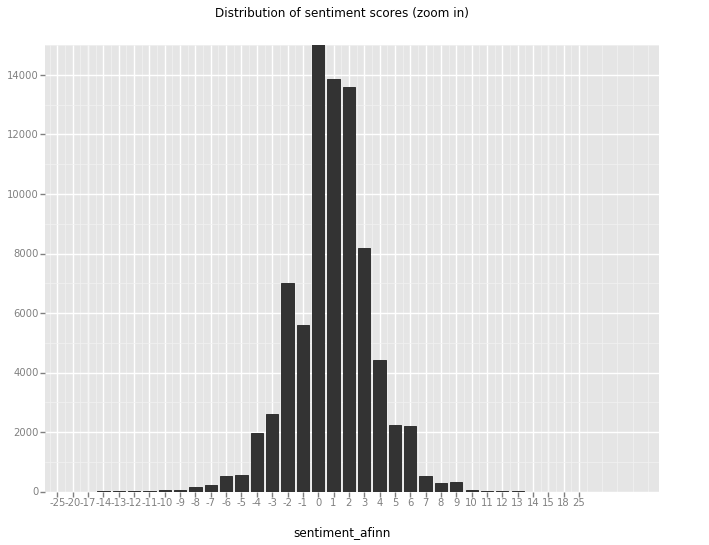

<ggplot: (145398066)>


In [25]:
p1 = ggplot(df, aes(x = 'sentiment_afinn')) + geom_bar() + ggtitle("Distribution of sentiment scores")
    
p2 = ggplot(df, aes(x = 'sentiment_afinn')) + geom_bar() + \
     scale_y_continuous(limits = (0,15000)) + ggtitle("Distribution of sentiment scores (zoom in)")
    
print(p1)
print(p2)

#### Clean up commercial/advertisment Tweets

After inspecting some of the data, there are quite a number of positive sentiment commercials. Let's add in a 'is_ad' column and tag up the commercials.

In [26]:
df['is_ad'] = 0

for index, row in df.iterrows():
    text = row['text'].lower()
    match = re.search(r'win a copy|giveaway|chance to win|cdiscount|available now|go in the draw', 
                      text)
    if match:
        df.set_value(index, 'is_ad', 1)

In [28]:
# print out a few to check
print(df[(df['sentiment_afinn'] >= 5) & (df['is_ad'] == 1)]['text'].value_counts())

RT @PlayStationJobs: #WIN a copy of #NoMansSky \n\nFOLLOW + RETWEET + LIKE to ENTER\n\nWinner picked at random on Tuesday 9 August 5pm https://…            769
RT @GamestaarUK: #Competition time! 5 lucky gamers! #NoMansSky or #FIFA17 up for grabs RT &amp; follow us for a chance to win! #Gamestaar https…            357
RT @GAMELutonAC: Would you like to win this awesome limited #NoMansSky stand?\n\nLike and retweet this tweet for your chance to win! https://…              181
RT @_J0rdi_: Since the hype is real...\nHow about a #NoMansSky Steam Key giveaway?\n\nRT &amp; Like to enter.\nI will pick a random winner in 2 hou…        135
RT @TheSpinoffTV: #NoMansSky GIVEAWAY! Wanna call this sweet merch yours? RT this and comment your best planet name to be in the draw. http…                 14
RT @kp0llux: #NoMansSky giveaway TODAY courtesy le amazing @binxtv &lt;3 Enter to win at https://t.co/US9HC22BS8 :) #CGN @TwitchPal https://t.…              13
RT @kevinG_harris: Coming back strong wi

### 2. Sentiment changes over time
#### Function to remove time of the day

In [29]:
def remove_time(t):
    return datetime.datetime(t.year, t.month, t.day)

#### Total sentiment score by date

In [30]:
df['date'] = df['created_at'].apply(parser.parse) # convert string to date object
df['date'] = df['date'].apply(remove_time)

In [36]:
df_no_ad = df[df['is_ad'] == 0]
by_date_afinn = pd.DataFrame(df_no_ad.groupby('date')['sentiment_afinn'].sum())
by_date_afinn['tweets'] = df_no_ad.groupby('date')['text'].count()
by_date_afinn['pos cnt'] = \
    df_no_ad[df_no_ad['sentiment_afinn'] > 0].groupby('date')['sentiment_afinn'].count()
by_date_afinn['neg cnt'] = \
    df_no_ad[df_no_ad['sentiment_afinn'] < 0].groupby('date')['sentiment_afinn'].count()
#by_date_afinn['date'] = by_date_afinn.index
by_date_afinn['date'] = by_date_afinn.index.day

by_date_afinn['sentiment_no_RT'] = df_no_ad[df_no_ad['retweet'] == 0].groupby('date')['sentiment_afinn'].sum()
by_date_afinn['tweets_no_RT'] = df_no_ad[df_no_ad['retweet'] == 0].groupby('date')['text'].count()

by_date_afinn = by_date_afinn.reset_index(drop=True)

In [37]:
by_date_afinn

,sentiment_afinn,tweets,pos cnt,neg cnt,date,sentiment_no_RT,tweets_no_RT
0,1019,1870,550,200,5,740,1099
1,881,1783,590,254,6,586,1167
2,1093,2623,788,571,7,1015,1582
3,3921,6012,2187,907,8,2444,3540
4,3448,6436,2030,782,9,2291,4047
5,6805,12114,3953,1315,10,4403,6326
6,6633,11623,4022,1652,11,4232,6795
7,4033,12791,4194,2191,12,2963,8199
8,7351,13117,5033,1835,13,4923,8211
9,5719,11537,4199,1953,14,4532,7242


#### Simple bar plot

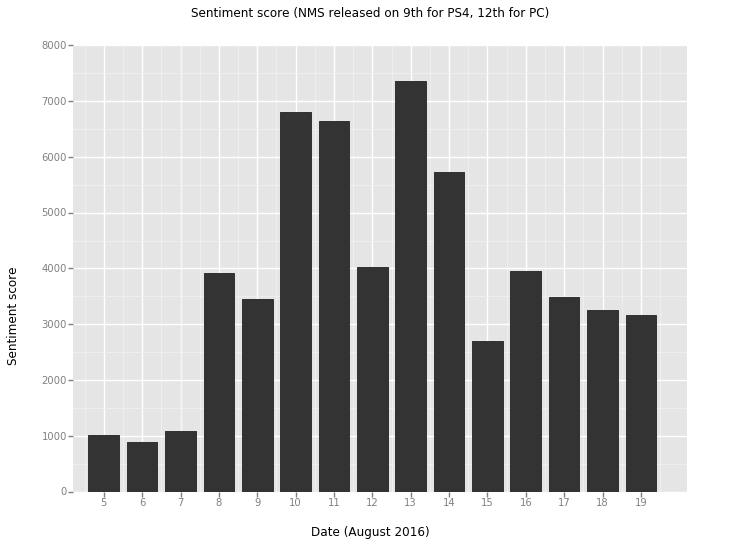

<ggplot: (176457764)>


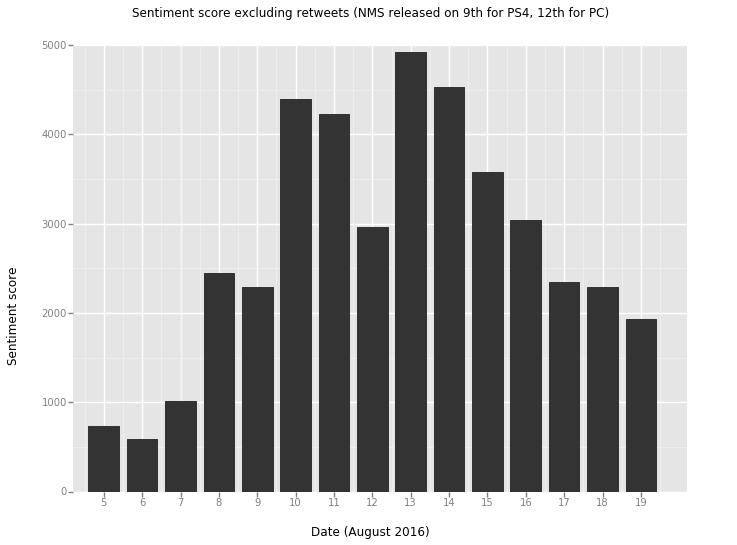

<ggplot: (176457785)>


In [46]:
p1 = ggplot(by_date_afinn, aes(x='date', weight='sentiment_afinn')) + geom_bar() + \
    xlab("Date (August 2016)") + ylab("Sentiment score") + \
    ggtitle("Sentiment score (NMS released on 9th for PS4, 12th for PC)") 
    
p2 = ggplot(by_date_afinn, aes(x='date', weight='sentiment_no_RT')) + geom_bar() + \
    xlab("Date (August 2016)") + ylab("Sentiment score") + \
    ggtitle("Sentiment score excluding retweets (NMS released on 9th for PS4, 12th for PC)")
    
print(p1)
print(p2)

The sentiment overall is quite positive, however we do see a drop on the 12th, which is the release day of PC version. This coincides with the rough launch of the PC version, according to reviews on Steam (by far the most popular PC games online store), there are many reported incidents of game crashes, performance issues on systems well above the minimal specification requirements.  
We do see a general decline in the following few days post game release, although there are numerous discussion over the internet and among various media outlet, that whether the game is up to expectation, without similar data set of other recent new game releases, it's too early to say whether the decline is faster than usual. 

#### Box plot

In [ ]:
def return_day(t):
    return t.day

df_no_ad['day'] = df_no_ad['date'].apply(return_day)

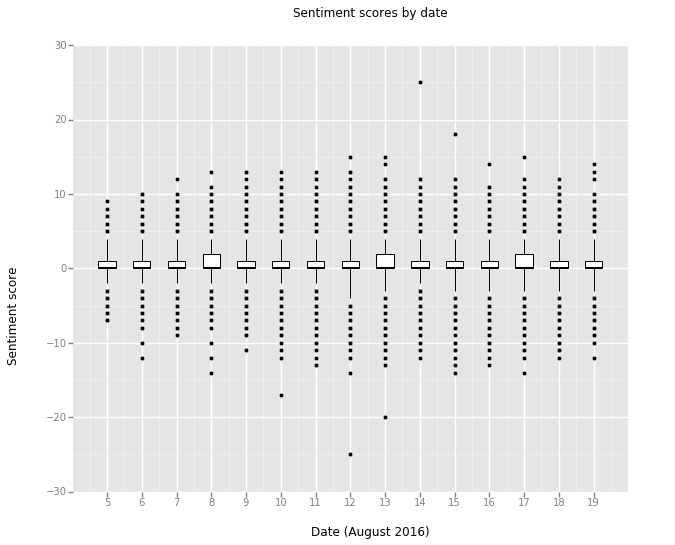

<ggplot: (299889426)>


In [47]:
p1 = ggplot(df_no_ad, aes(x='day', y='sentiment_afinn', group = 'day')) + geom_boxplot() + \
    ylab("Sentiment score") + xlab("Date (August 2016)") + \
    ggtitle("Sentiment scores by date")
print(p1)